In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install category_encoders
#!pip install optuna
#!pip install lightgbm
#!pip install xgboost
#!pip install catboost 1.2.0
#!pip install geopy
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('rocket')
#!pip install pingouin
from time import time
import pingouin
from scipy.stats import ttest_ind
#!pip install category_encoders
from category_encoders import WOEEncoder
#from imblearn.over_sampling import SMOTE
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from geopy.distance import great_circle

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

import optuna
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("fraudTrain.csv")
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
test = pd.read_csv("fraudTest.csv")
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
train['split'] = 'train'
test['split']='test'
df = pd.concat([train,test],axis=0).reset_index(drop=True)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,split
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,train
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,train
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,train
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,train
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,train


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [6]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split                    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'split'],
      dtype='object')

In [9]:
df.drop(columns=['Unnamed: 0','street','state','first','last','trans_num','unix_time'],inplace=True)

In [10]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,split
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,train
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,49.159047,-118.186462,0,train
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,train
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,47.034331,-112.561071,0,train
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,38.674999,-78.632459,0,train


In [11]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [12]:
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day_name()
df['month'] = df['trans_date_trans_time'].dt.month

In [13]:
df['merchant'] = df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [14]:
df[['merchant']].head()

,merchant
0,"Rippin, Kub and Mann"
1,"Heller, Gutmann and Zieme"
2,Lind-Buckridge
3,"Kutch, Hermiston and Farrell"
4,Keeling-Crist


In [15]:
#Date of birth --> Age of custome
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (df['trans_date_trans_time'].dt.year - df['dob'].dt.year).astype(int)
df.drop(columns='dob',inplace=True)

In [16]:
df['distance_km'] = df.apply(lambda col : round(great_circle((col['lat'],col['long']),
                                         (col['merch_lat'],col['merch_long'])).kilometers,2),axis=1)

In [17]:
df.drop(columns=['lat','long','merch_lat','merch_long'],inplace=True)

In [18]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,Tuesday,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,0,train,0,Tuesday,1,41,30.21
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,Malad City,83252,4154,Nature conservation officer,0,train,0,Tuesday,1,57,108.21
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,1939,Patent attorney,0,train,0,Tuesday,1,52,95.67
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,99,Dance movement psychotherapist,0,train,0,Tuesday,1,33,77.56


EDA

In [19]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
trans_date_trans_time,1852394,2020-01-20 21:31:46.801827328,2019-01-01 00:00:18,2019-07-23 04:13:43.750000128,2020-01-02 01:15:31,2020-07-23 12:11:25.249999872,2020-12-31 23:59:34,NaN
cc_num,1852394.0,417386038393710400.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0,1309115265318734848.0
amt,1852394.0,70.063567,1.0,9.64,47.45,83.1,28948.9,159.253975
zip,1852394.0,48813.258191,1257.0,26237.0,48174.0,72042.0,99921.0,26881.845966
city_pop,1852394.0,88643.674509,23.0,741.0,2443.0,20328.0,2906700.0,301487.618344
is_fraud,1852394.0,0.00521,0.0,0.0,0.0,0.0,1.0,0.071992
hour,1852394.0,12.806119,0.0,7.0,14.0,19.0,23.0,6.815753
month,1852394.0,7.152067,1.0,4.0,7.0,10.0,12.0,3.424954
age,1852394.0,46.21138,14.0,33.0,44.0,57.0,96.0,17.395446
distance_km,1852394.0,76.111833,0.02,55.32,78.22,98.51,152.12,29.117007


In [20]:
df.describe(include='object').T

,count,unique,top,freq
merchant,1852394,693,Kilback LLC,6262
category,1852394,14,gas_transport,188029
gender,1852394,2,F,1014749
city,1852394,906,Birmingham,8040
job,1852394,497,Film/video editor,13898
split,1852394,2,train,1296675
day,1852394,7,Monday,369418


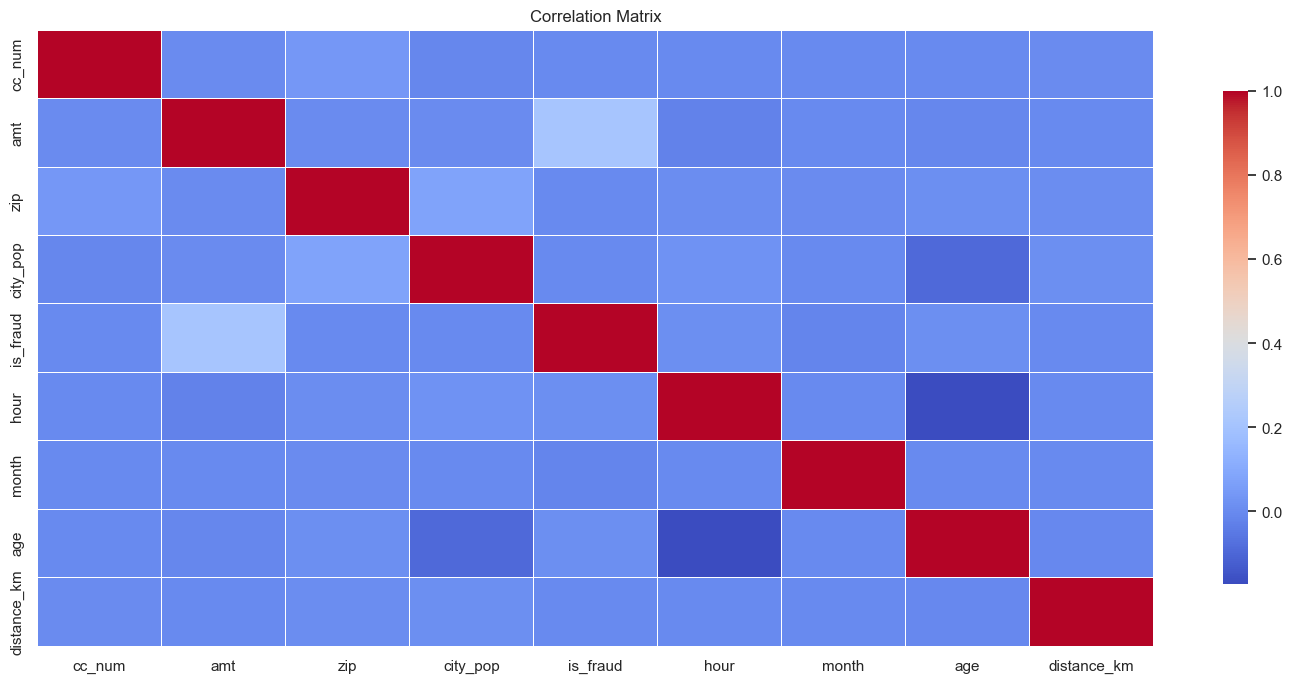

In [21]:
sns.heatmap(df.select_dtypes(include='number').corr(),
            annot=None,cmap='coolwarm',fmt='.2f',linewidths=0.5,cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix')
plt.show()

In [22]:
df.select_dtypes(include='number').corr()

,cc_num,amt,zip,city_pop,is_fraud,hour,month,age,distance_km
cc_num,1.000000,0.001826,0.041504,-0.009118,-0.001125,-0.000902,-0.000188,-0.000131,0.003082
amt,0.001826,1.000000,0.001979,0.004921,0.209308,-0.024891,-0.002593,-0.010695,-0.000538
zip,0.041504,0.001979,1.000000,0.077601,-0.002190,0.005947,0.001160,0.010359,0.006750
city_pop,-0.009118,0.004921,0.077601,1.000000,0.000325,0.019949,-0.000510,-0.090889,0.010989
is_fraud,-0.001125,0.209308,-0.002190,0.000325,1.000000,0.013196,-0.016417,0.010927,0.000359
hour,-0.000902,-0.024891,0.005947,0.019949,0.013196,1.000000,-0.000986,-0.173014,0.000391
month,-0.000188,-0.002593,0.001160,-0.000510,-0.016417,-0.000986,1.000000,0.000060,-0.000067
age,-0.000131,-0.010695,0.010359,-0.090889,0.010927,-0.173014,0.000060,1.000000,-0.004155
distance_km,0.003082,-0.000538,0.006750,0.010989,0.000359,0.000391,-0.000067,-0.004155,1.000000


In [23]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
sns.set_palette('rocket')

In [24]:
def bar_plot(col):
    def top_frauds(col):
        return pd.DataFrame(df.loc[df['is_fraud']==1,[col]].value_counts()).reset_index().head(10)
    ax=sns.barplot(data=top_frauds(col),x=col,y='count',palette='bone')
    ax.bar_label(ax.containers[0])
    plt.title(f'Top 10 Frauds | {col}',fontsize=16,fontweight='bold')
    plt.xticks(rotation=45,fontweight='bold')

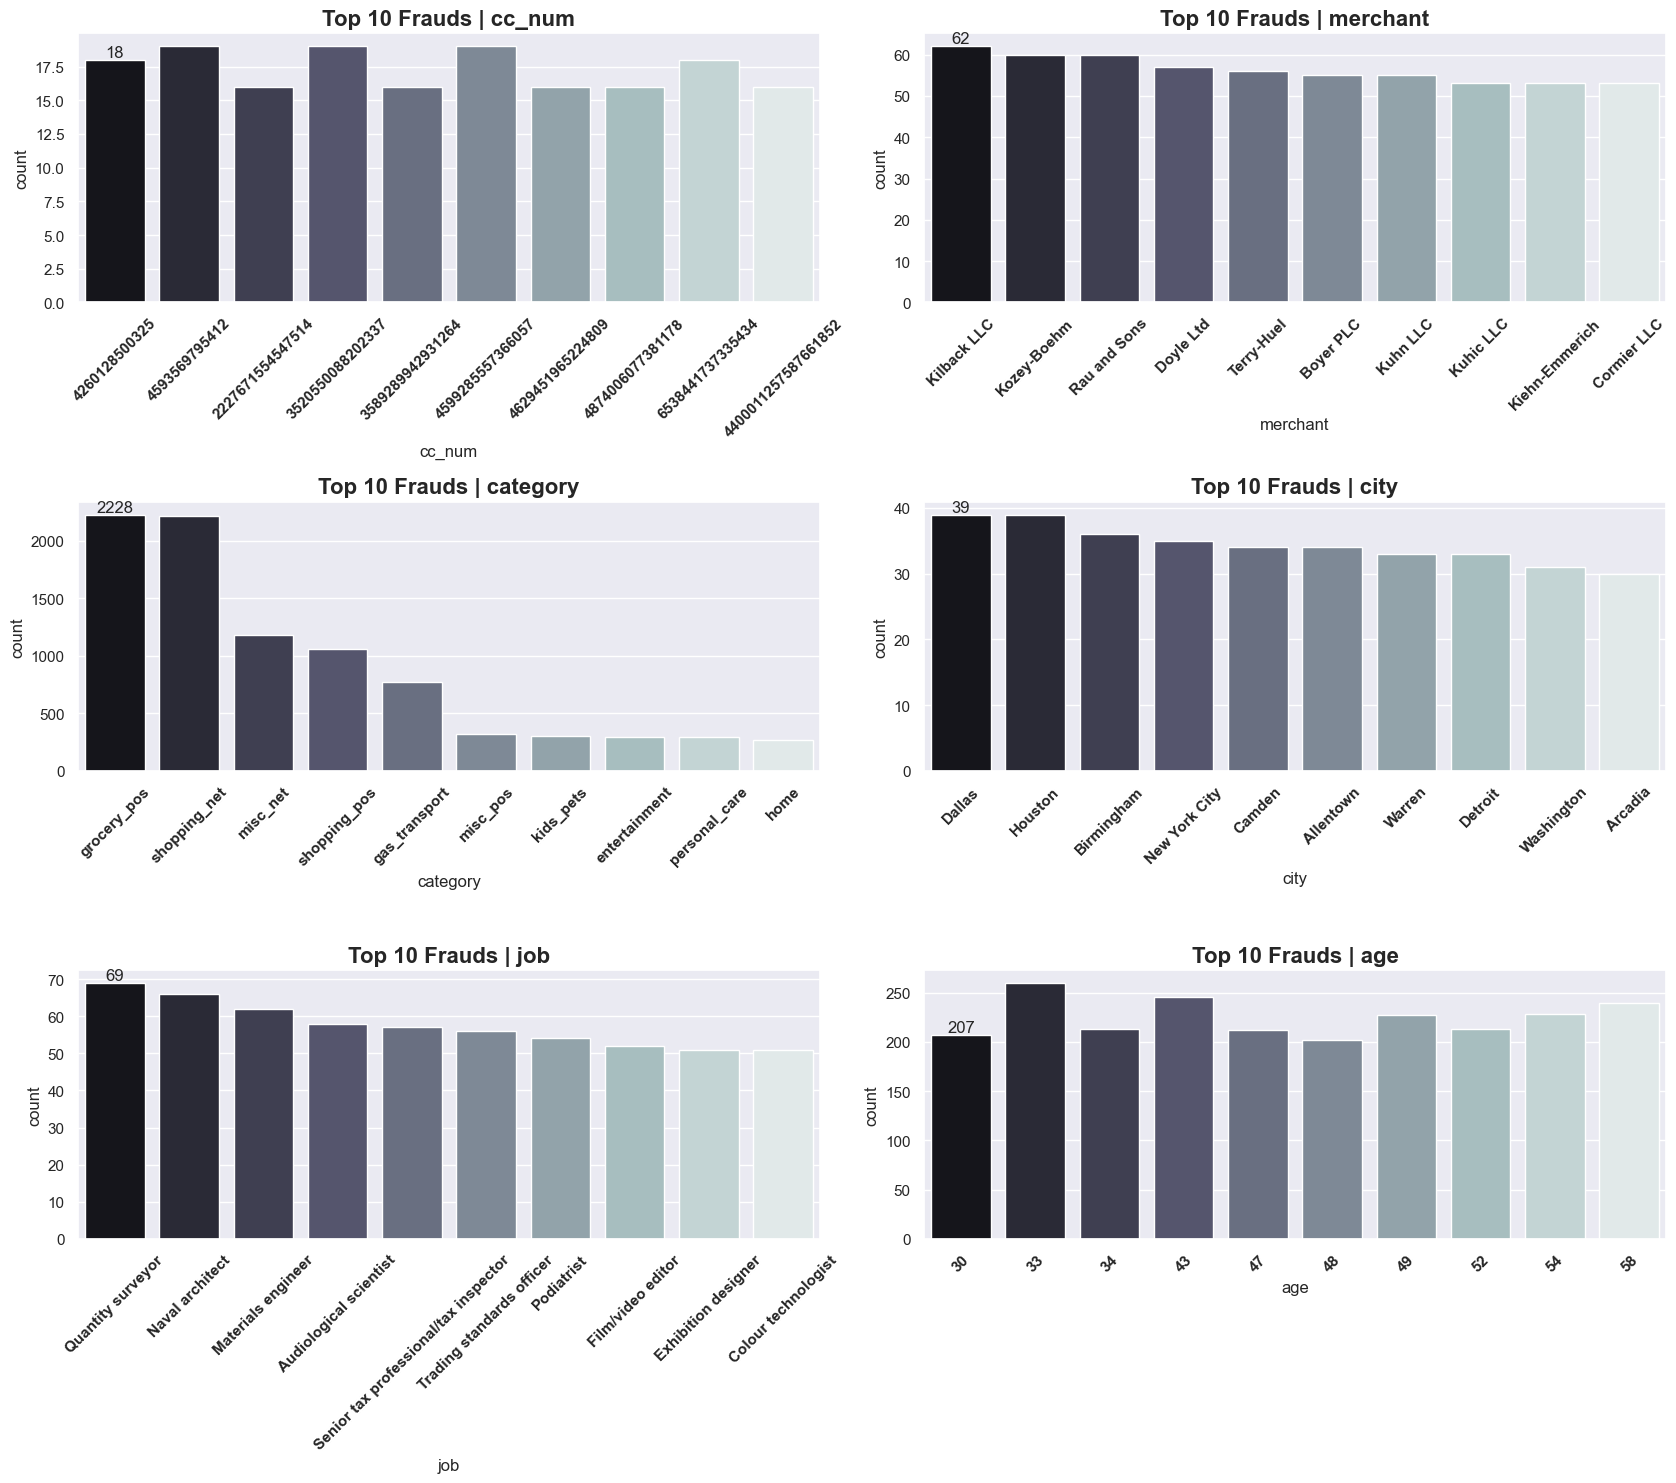

In [25]:
plt.figure(figsize=(17,15))
for idx,val in enumerate(['cc_num','merchant','category','city','job','age']):
    plt.subplot(3,2,idx+1)
    bar_plot(val)
plt.tight_layout()

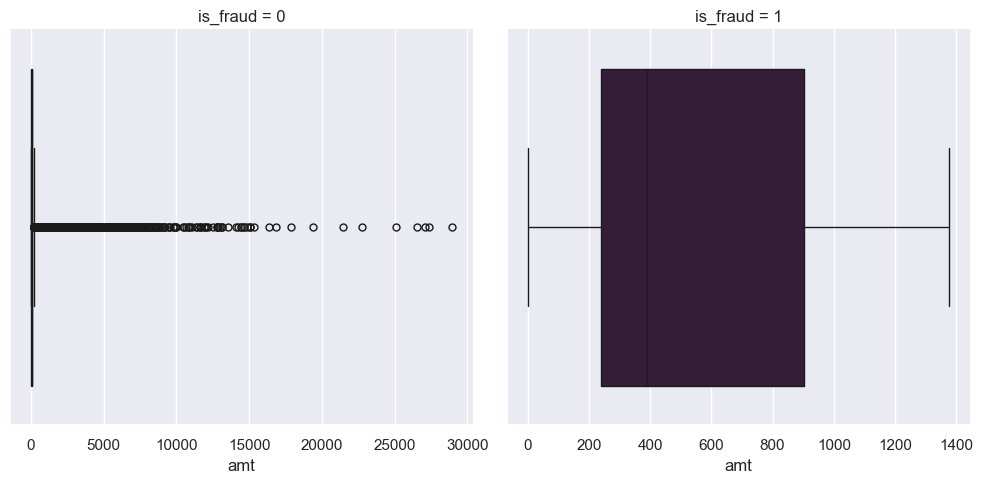

In [26]:
sns.catplot(data=df,x='amt',col='is_fraud',kind='box',sharex=False)

In [28]:
def pie_bar_plot(col):
    print(df[col].value_counts())
    sns.set_palette('viridis')
    fig,axs=plt.subplots(1,2)
    axs[0].pie(df[col].value_counts().values.tolist(),autopct='%.2f%%',textprops={'fontsize':25},explode=[0,0.05],shadow=True)
    sns.countplot(data=df,x=col,ax=axs[1])
    fig.legend(labels=df[col].value_counts().index.tolist(),loc='upper left',fontsize=20)
    fig.tight_layout()
    fig.show()

gender
F    1014749
M     837645
Name: count, dtype: int64


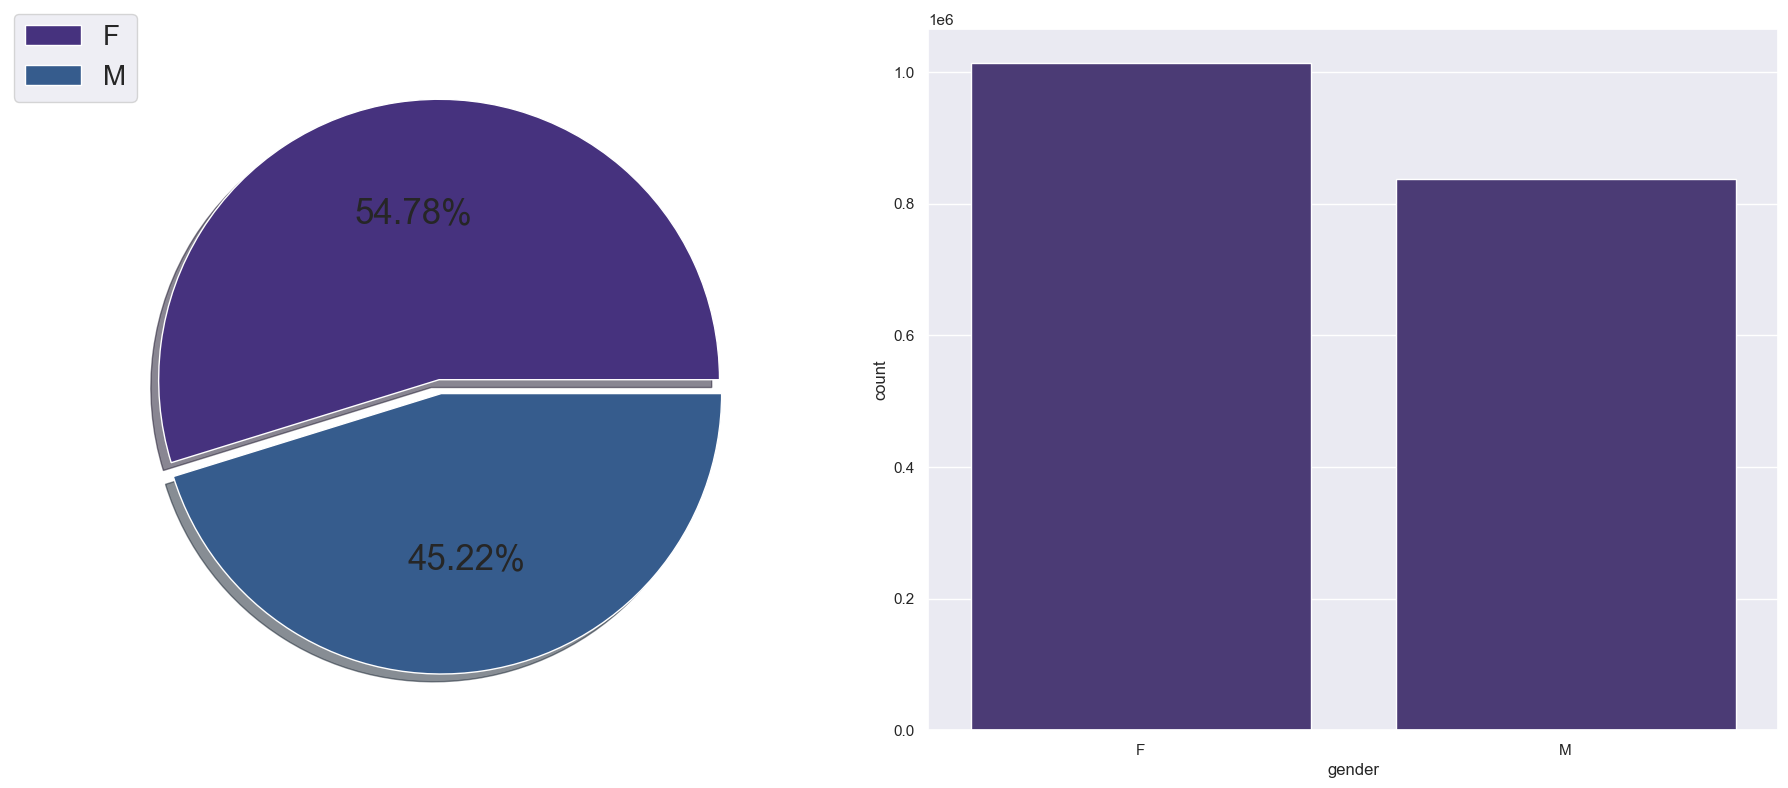

In [29]:
pie_bar_plot('gender')

is_fraud
0    1842743
1       9651
Name: count, dtype: int64


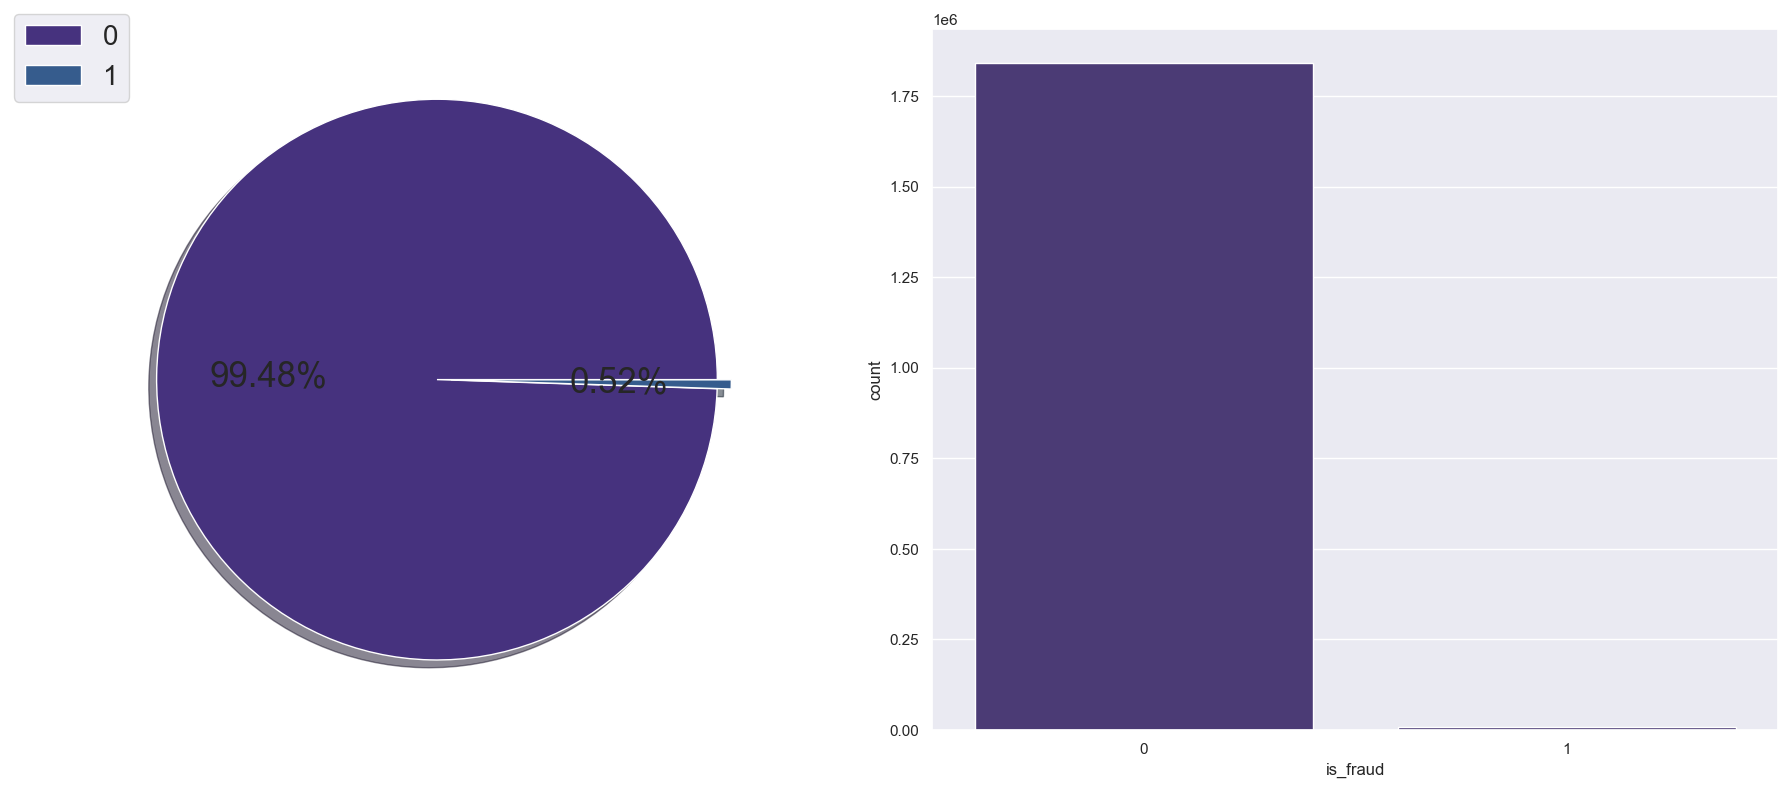

In [30]:
pie_bar_plot('is_fraud')

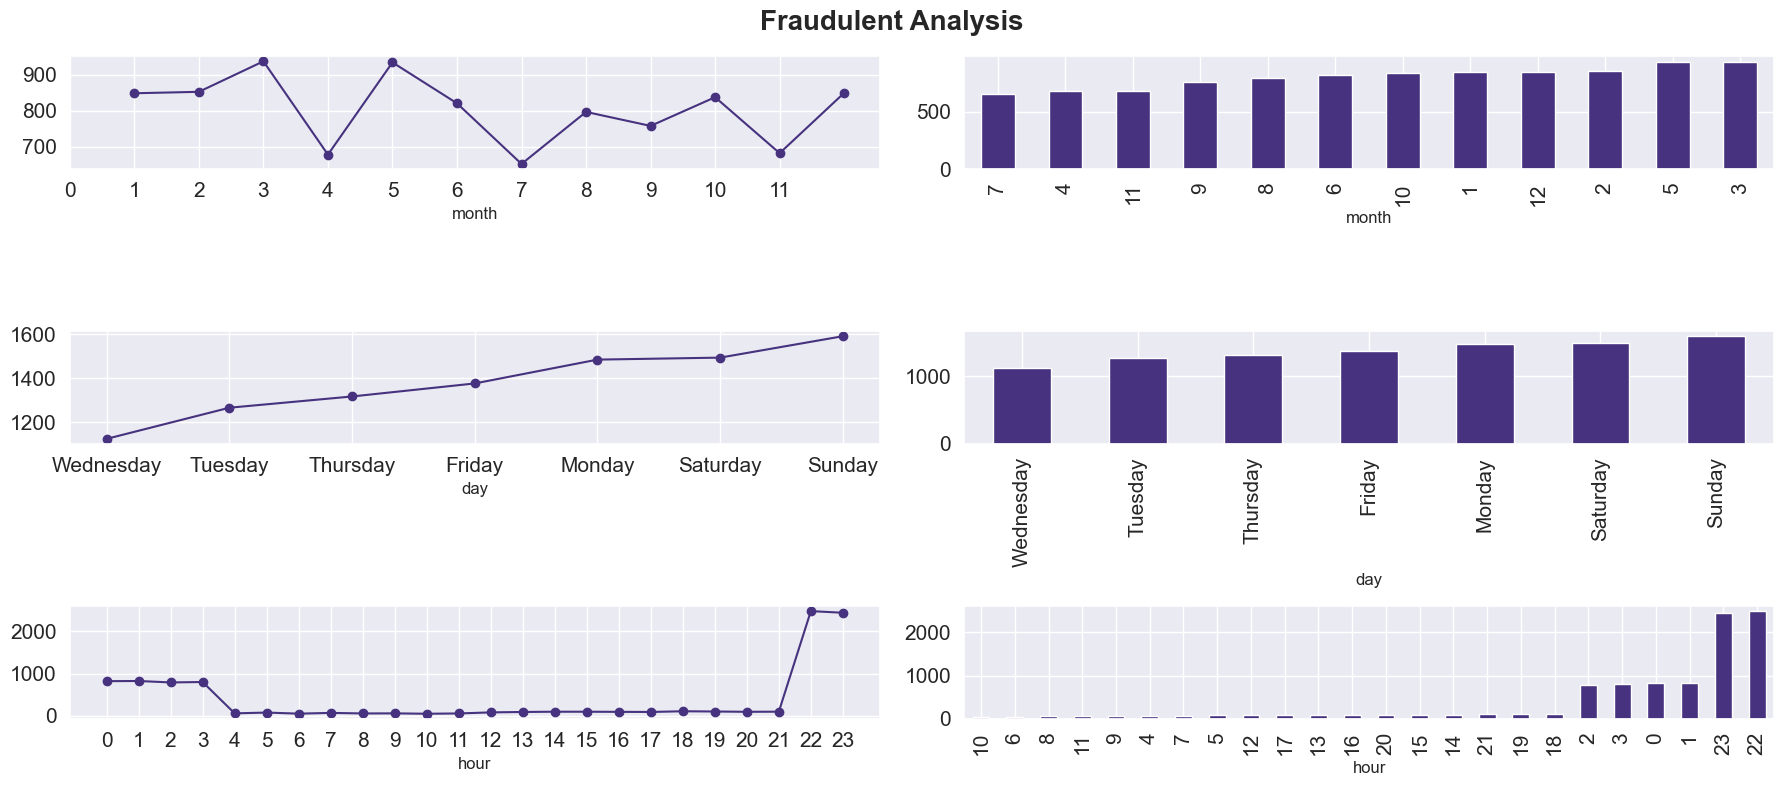

In [32]:
fig,axs = plt.subplots(3,2)
#Month
df.loc[df['is_fraud']==1,'month'].value_counts().sort_index().plot(kind='line',ax=axs[0,0],marker='o',fontsize=15)
axs[0,0].set_xticks(range(0,12))
df.loc[df['is_fraud']==1,'month'].value_counts(ascending=True).plot(kind='bar',ax=axs[0,1],fontsize=15)
fig.suptitle('Fraudulent Analysis', fontsize=18, fontweight='bold')
##Day
df.loc[df['is_fraud']==1,'day'].value_counts(ascending=True).plot(kind='line',ax=axs[1,0],marker='o',fontsize=15)
df.loc[df['is_fraud']==1,'day'].value_counts(ascending=True).plot(kind='bar',ax=axs[1,1],fontsize=15)
#Hour
df.loc[df['is_fraud']==1,'hour'].value_counts().sort_index().plot(kind='line',ax=axs[2,0],marker='o',fontsize=15)
axs[2,0].set_xticks(range(0,24))
df.loc[df['is_fraud']==1,'hour'].value_counts(ascending=True).plot(kind='bar',ax=axs[2,1],fontsize=15)
fig.suptitle('Fraudulent Analysis', fontsize=20, fontweight='bold')
plt.tight_layout()

In [33]:
df.loc[df['is_fraud']==1,['gender']].value_counts()

gender
F         4899
M         4752
Name: count, dtype: int64

In [34]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,zip,city_pop,job,is_fraud,split,hour,day,month,age,distance_km
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,28654,3495,"Psychologist, counselling",0,train,0,Tuesday,1,31,78.60
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,99160,149,Special educational needs teacher,0,train,0,Tuesday,1,41,30.21
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,Malad City,83252,4154,Nature conservation officer,0,train,0,Tuesday,1,57,108.21
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,59632,1939,Patent attorney,0,train,0,Tuesday,1,52,95.67
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,Doe Hill,24433,99,Dance movement psychotherapist,0,train,0,Tuesday,1,33,77.56


In [35]:
df.sort_values(['cc_num', 'trans_date_trans_time'],inplace=True)
df['hours_diff_bet_trans']=((df.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))

In [36]:
df.loc[df['hours_diff_bet_trans'].isna(),'hours_diff_bet_trans'] = 0
df['hours_diff_bet_trans'] = df['hours_diff_bet_trans'].astype(int)

                T          p-val
T-test  27.266899  7.200860e-158


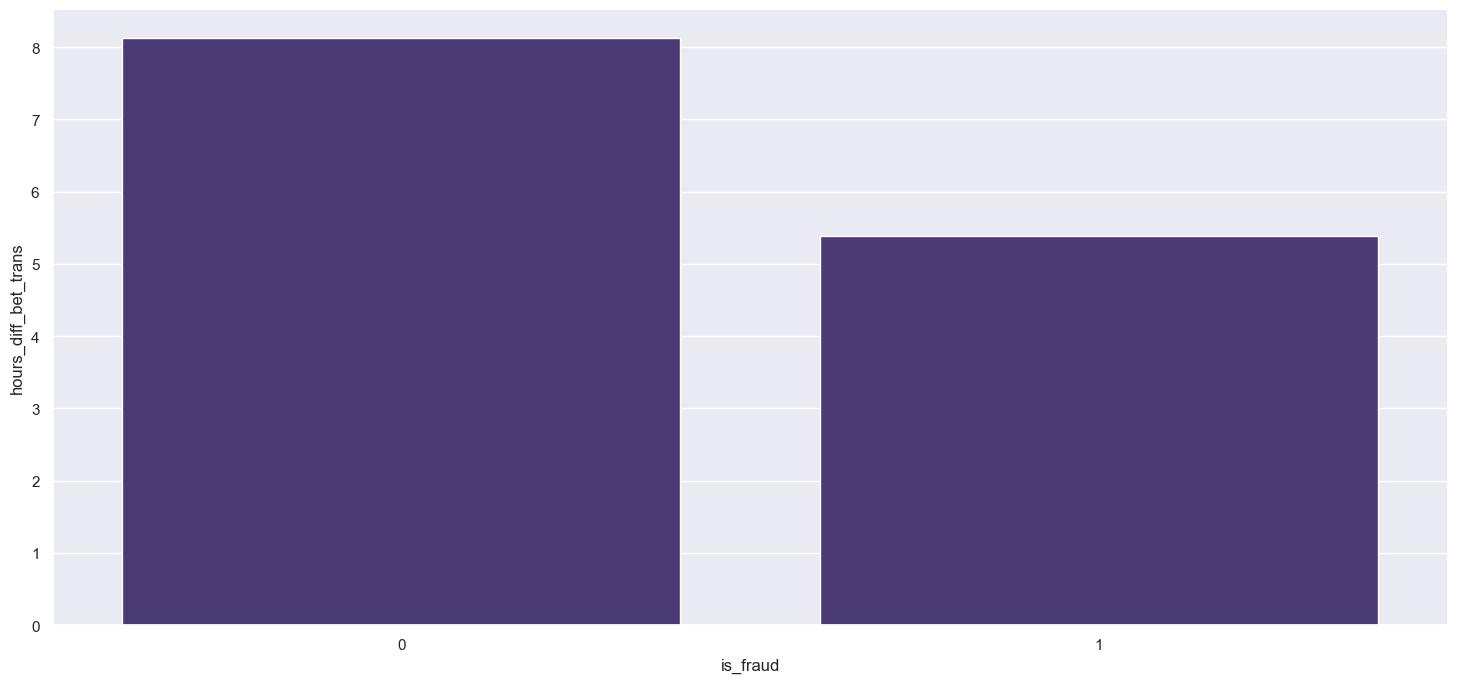

In [37]:
print(pingouin.ttest(df[df['is_fraud'] == 0]['hours_diff_bet_trans'],
              df[df['is_fraud'] == 1]['hours_diff_bet_trans'],
              alternative='two-sided')[['T','p-val']])
sns.barplot(data=df,x='is_fraud',y='hours_diff_bet_trans',ci=None)
plt.show()

In [39]:
df['day'] = df['trans_date_trans_time'].dt.weekday

In [40]:
freq = df.groupby('cc_num').size()
df['cc_freq'] = df['cc_num'].apply(lambda x : freq[x])
df[['cc_num','cc_freq']].head()

,cc_num,cc_freq
1017,60416207185,2196
2724,60416207185,2196
2726,60416207185,2196
2882,60416207185,2196
2907,60416207185,2196


In [41]:
def hist_show(col):
    fig,axs = plt.subplots(1,2,sharex=True)
    for i in [0,1]:
        sns.histplot(df[df["is_fraud"]==i][col], bins=6,ax=axs[i])

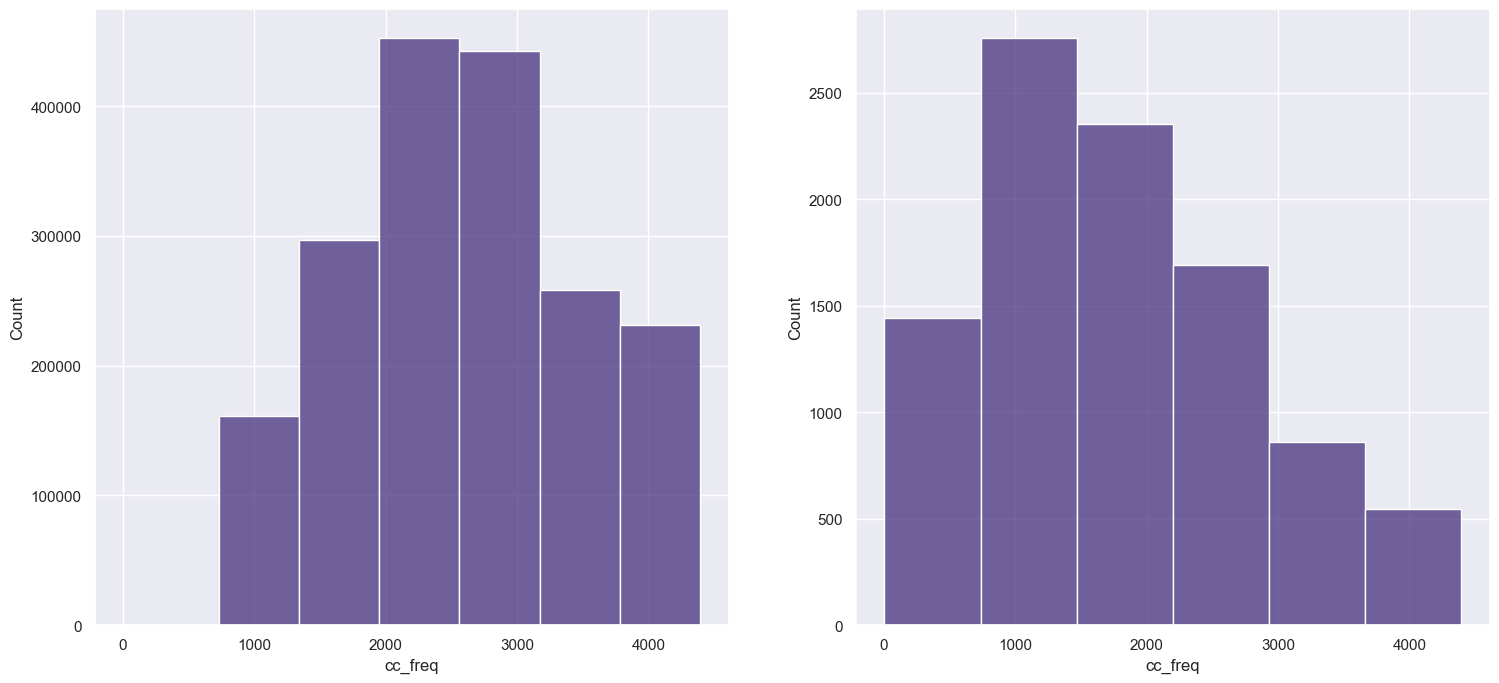

In [42]:
hist_show('cc_freq')

In [43]:
def class_det(x):
    for idx,val in enumerate(list(range(800,5000,800))):
        if x < val:
            return idx+1

In [44]:
df['cc_freq_class'] = df['cc_freq'].apply(class_det)
print(df['cc_freq_class'].unique())

[3 1 2 4 5 6]


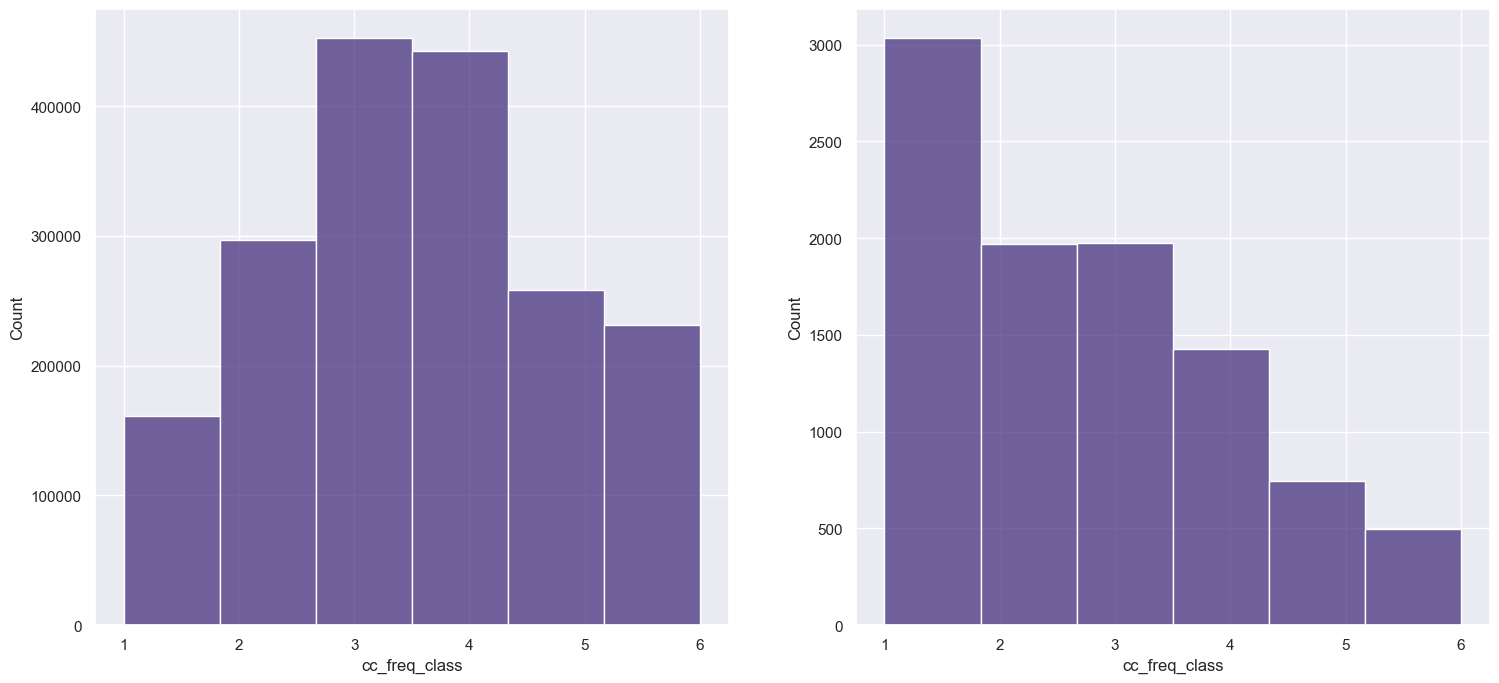

In [45]:
hist_show('cc_freq_class')

Очевидно, что мошенничество чаще происходит с кредитными картами, которые меньше используются (новыми), а для подлинных операций оно соответствует нормальному распределению

In [46]:
df.drop(columns=['cc_num','trans_date_trans_time','city_pop'],inplace=True)

In [47]:
df.columns

Index(['merchant', 'category', 'amt', 'gender', 'city', 'zip', 'job',
       'is_fraud', 'split', 'hour', 'day', 'month', 'age', 'distance_km',
       'hours_diff_bet_trans', 'cc_freq', 'cc_freq_class'],
      dtype='object')

In [48]:
df = df[['cc_freq','cc_freq_class','city','job','age','gender','merchant', 'category',
         'distance_km','month','day','hour','hours_diff_bet_trans','amt','is_fraud','split']]
df.head()

,cc_freq,cc_freq_class,city,job,age,gender,merchant,category,distance_km,month,day,hour,hours_diff_bet_trans,amt,is_fraud,split
1017,2196,3,Fort Washakie,Information systems manager,33,F,"Jones, Sawayn and Romaguera",misc_net,127.61,1,1,12,0,7.27,0,train
2724,2196,3,Fort Washakie,Information systems manager,33,F,Berge LLC,gas_transport,110.31,1,2,8,19,52.94,0,train
2726,2196,3,Fort Washakie,Information systems manager,33,F,Luettgen PLC,gas_transport,21.79,1,2,8,0,82.08,0,train
2882,2196,3,Fort Washakie,Information systems manager,33,F,Daugherty LLC,kids_pets,87.20,1,2,12,3,34.79,0,train
2907,2196,3,Fort Washakie,Information systems manager,33,F,Beier and Sons,home,74.21,1,2,13,0,27.18,0,train


In [49]:
df.day.value_counts()

day
0    369418
6    343677
1    270340
5    263227
4    215078
3    206741
2    183913
Name: count, dtype: int64

In [50]:
df.month.value_counts()

month
12    280598
8     176118
6     173869
7     172444
5     146875
3     143789
11    143056
9     140185
10    138106
4     134970
1     104727
2      97657
Name: count, dtype: int64

In [51]:
df.query('is_fraud == 1').head()

,cc_freq,cc_freq_class,city,job,age,gender,merchant,category,distance_km,month,day,hour,hours_diff_bet_trans,amt,is_fraud,split
102490,2196,3,Fort Washakie,Information systems manager,33,F,Marks Inc,gas_transport,48.05,3,4,1,6,13.17,1,train
102556,2196,3,Fort Washakie,Information systems manager,33,F,Cummings LLC,gas_transport,88.19,3,4,2,1,11.74,1,train
104145,2196,3,Fort Washakie,Information systems manager,33,F,Labadie LLC,personal_care,114.98,3,4,23,20,19.16,1,train
106627,2196,3,Fort Washakie,Information systems manager,33,F,Barrows PLC,shopping_pos,80.65,3,5,22,23,830.06,1,train
106628,2196,3,Fort Washakie,Information systems manager,33,F,"Windler, Goodwin and Kovacek",home,96.18,3,5,22,0,261.79,1,train


In [73]:
x_train = df[df['split']=='train'].drop(['split','is_fraud'],axis=1)
y_train = df[df['split']=='train']['is_fraud']
x_test = df[df['split']=='test'].drop(['split','is_fraud'],axis=1)
y_test = df[df['split']=='test']['is_fraud']

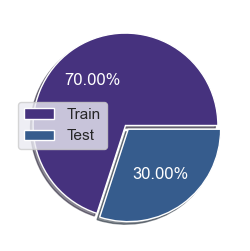

In [74]:
plt.figure(figsize=(3,3))
plt.pie([len(x_train),len(x_test)],autopct='%.2f%%'
        ,textprops={'color':'white'},explode=[0,0.05],shadow=True)
plt.legend(['Train','Test'])
plt.show()

In [75]:
df.select_dtypes(include='number').columns

Index(['cc_freq', 'cc_freq_class', 'age', 'distance_km', 'month', 'day',
       'hour', 'hours_diff_bet_trans', 'amt', 'is_fraud'],
      dtype='object')

In [76]:
df.select_dtypes(include='object').columns

Index(['city', 'job', 'gender', 'merchant', 'category', 'split'], dtype='object')

In [77]:
num_cols = ['cc_freq','cc_freq_class','age', 'distance_km', 'month', 'day', 'hour', 'hours_diff_bet_trans', 'amt']
cat_cols = ['city', 'job', 'gender', 'merchant', 'category']

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [79]:
num_pipeline = Pipeline(steps=[
    ('scale',StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('woe',WOEEncoder())
])

In [80]:
from sklearn.compose import ColumnTransformer

In [81]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [ ]:
def objective(trial):
    """Define the objective function"""

    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss'
    }

    estimator = XGBClassifier(**param)

    clf_pipeline = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', estimator)
        ])
    f1 = cross_val_score(clf_pipeline, x_train, y_train, cv=3, scoring = 'f1').mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

print(study.best_trial)
print('finish')

In [ ]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')

trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.8410249412999886
  Params: 
    max_depth: 8
    learning_rate: 0.10189103573494877
    n_estimators: 222
    min_child_weight: 7
    gamma: 3.940462845968263e-08
    subsample: 0.901907747688238
    colsample_bytree: 0.5297947308780412
    reg_alpha: 0.4746236881332461
    reg_lambda: 3.1278932569343864e-06

Number of finished trials: 300
Best trial:
  Value: 0.8253094930765948
  Params: 
    max_depth: 7
    learning_rate: 0.08079201671967252
    n_estimators: 439
    min_child_weight: 9
    gamma: 1.9952453880313695e-07
    subsample: 0.9997173809054319
    colsample_bytree: 0.6195237799455112
    reg_alpha: 0.6838160681765109
    reg_lambda: 0.12431227610790711

In [ ]:
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    
    model = LGBMClassifier(**param)

    clf_pipeline_lgb = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', model)
        ])
    
    f1 = cross_val_score(clf_pipeline_lgb, x_train, y_train, cv=3, scoring= 'f1').mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

print(study.best_trial)
print('finish')

In [ ]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

In [84]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [68]:
x_train_70, x_test_30, y_train_70, y_test_30 = train_test_split(x_test, y_test, test_size = 0.3, random_state = 42)

In [69]:
def objective(trial):
    """Define the objective function"""

     # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=2, high=53, step=10)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=6, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    
    param = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }

    model = RandomForestClassifier(**param)

    clf_pipeline_rf = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', model)
        ])
    f1 = cross_val_score(clf_pipeline_rf, x_test_30, y_test_30, cv=3, scoring = 'f1', n_jobs = -1).mean()
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

print(study.best_trial)
print('finish')

[I 2023-12-16 11:46:37,695] A new study created in memory with name: no-name-6a0be9cf-591a-4dc8-bae8-4f721502944c
[I 2023-12-16 11:46:48,707] Trial 0 finished with value: 0.08589294139954932 and parameters: {'n_estimators': 300, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.08589294139954932.
[I 2023-12-16 11:47:11,793] Trial 1 finished with value: 0.5656648376393599 and parameters: {'n_estimators': 200, 'max_depth': 52, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.5656648376393599.
[I 2023-12-16 11:47:24,985] Trial 2 finished with value: 0.6013714842662211 and parameters: {'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.6013714842662211.
[I 2023-12-16 11:48:19,159] Trial 3 finished with value: 0.5942029445277203 and parameters: {'n_estimators': 500, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with valu

FrozenTrial(number=162, state=1, values=[0.6231028836169024], datetime_start=datetime.datetime(2023, 12, 16, 12, 43, 52, 577149), datetime_complete=datetime.datetime(2023, 12, 16, 12, 44, 4, 852020), params={'n_estimators': 100, 'max_depth': 52, 'min_samples_split': 4, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=100), 'max_depth': IntDistribution(high=52, log=False, low=2, step=10), 'min_samples_split': IntDistribution(high=6, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=4, log=False, low=1, step=1)}, trial_id=162, value=None)
finish


In [70]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 300
Best trial:
  Value: 0.6231028836169024
  Params: 
    n_estimators: 100
    max_depth: 52
    min_samples_split: 4
    min_samples_leaf: 1


Number of finished trials: 300
Best trial:
  Value: 0.6231028836169024
  Params: 
    n_estimators: 100
    max_depth: 52
    min_samples_split: 4
    min_samples_leaf: 1

In [61]:
params = {
    'max_depth' : 8,
    'learning_rate': 0.10189103573494877,
    'n_estimators': 222,
    'min_child_weight': 7,
    'gamma': 3.940462845968263e-08,
    'subsample': 0.901907747688238,
    'colsample_bytree': 0.5297947308780412,
    'reg_alpha': 0.4746236881332461,
    'reg_lambda': 3.1278932569343864e-06}

model_fn = XGBClassifier(**params)

clf_pipeline_xgb_fn = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', model_fn)
            ])

clf_pipeline_xgb_fn.fit(x_train, y_train)

xgb_pred = clf_pipeline_xgb_fn.predict(x_test)

print('Recall Score: ',recall_score(y_test,xgb_pred))
print('Precision: ',precision_score(y_test,xgb_pred))
print('F1-Score: ',f1_score(y_test,xgb_pred))
print('Accuracy Score: ',accuracy_score(y_test,xgb_pred))

Recall Score:  0.2857808857808858
Precision:  0.8757142857142857
F1-Score:  0.4309314586994728
Accuracy Score:  0.9970866571054796


In [72]:
probability = clf_pipeline_xgb_fn.predict_proba(x_test[:1])
probability[0][0]

0.9999115

In [62]:
params = {
    'lambda_l1' : 0.0001306754093068567,
    'lambda_l2' : 3.390365176379406,
    'num_leaves' : 157,
    'feature_fraction' : 0.9884522879693689,
    'bagging_fraction' : 0.9449599178756362,
    'bagging_freq' : 1,
    'min_child_samples' : 76}

model_fn_lgbm = LGBMClassifier(**params)

clf_pipeline_lgbm_fn = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', model_fn_lgbm)
            ])

clf_pipeline_lgbm_fn.fit(x_train, y_train)

lgbm_pred = clf_pipeline_lgbm_fn.predict(x_test)

print('Recall Score: ',recall_score(y_test,lgbm_pred))
print('Precision: ',precision_score(y_test,lgbm_pred))
print('F1-Score: ',f1_score(y_test,lgbm_pred))
print('Accuracy Score: ',accuracy_score(y_test,lgbm_pred))

[LightGBM] [Warning] feature_fraction is set=0.9884522879693689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9884522879693689
[LightGBM] [Warning] lambda_l1 is set=0.0001306754093068567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001306754093068567
[LightGBM] [Warning] lambda_l2 is set=3.390365176379406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.390365176379406
[LightGBM] [Warning] bagging_fraction is set=0.9449599178756362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9449599178756362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9884522879693689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9884522879693689
[LightGBM] [Warning] lambda_l1 is set=0.0001306754093068567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001306754093068567
[LightGBM] [Warning] lambda

In [63]:
params = {
    'n_estimators' : 100,
    'max_depth' : 52,
    'min_samples_split' : 4,
    'min_samples_leaf' : 1}

model_fn_rf = RandomForestClassifier(**params)

clf_pipeline_rf_fn = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', model_fn_rf)
            ])

clf_pipeline_rf_fn.fit(x_train, y_train)

rfc_pred = clf_pipeline_rf_fn.predict(x_test)

print('Recall Score: ',recall_score(y_test,rfc_pred))
print('Precision: ',precision_score(y_test,rfc_pred))
print('F1-Score: ',f1_score(y_test,rfc_pred))
print('Accuracy Score: ',accuracy_score(y_test,rfc_pred))

Recall Score:  0.2881118881118881
Precision:  0.9196428571428571
F1-Score:  0.4387646432374866
Accuracy Score:  0.9971550369881181


In [64]:
results = pd.DataFrame({'XGBoost' : [recall_score(y_test,xgb_pred),  precision_score(y_test,xgb_pred), f1_score(y_test,xgb_pred)],
                        'Lightgbm' : [recall_score(y_test,lgbm_pred),  precision_score(y_test,lgbm_pred), f1_score(y_test,lgbm_pred)],
                        'RandomForest' : [recall_score(y_test,rfc_pred),  precision_score(y_test,rfc_pred), f1_score(y_test,rfc_pred)]},
                       index = ['Recall', 'Precision', 'F1-score'])
results

,XGBoost,Lightgbm,RandomForest
Recall,0.285781,0.325408,0.288112
Precision,0.875714,0.861728,0.919643
F1-score,0.430931,0.472420,0.438765


In [74]:
with open("model.pkl", "wb") as f:
    pickle.dump(clf_pipeline_rf_fn, f)

**LOF and ISF**

In [65]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [66]:
#df_LI = df.copy()

In [67]:
#X = df_LI.drop(['is_fraud', 'split'], axis = 1)
#y = df_LI['is_fraud']

In [68]:
#pipe_num = Pipeline([('scaler', StandardScaler())])

#ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#pipe_cat = Pipeline([('woe',WOEEncoder())])

#col_transformer = ColumnTransformer([('num_preproc', pipe_num, [x for x in X.columns if X[x].dtype!='object']),
                                     #('cat_preproc', pipe_cat, [x for x in X.columns if X[x].dtype=='object'])])

In [69]:
#res = col_transformer.fit_transform(X, y)

#res_df = pd.DataFrame(res, columns = [x.split('__')[-1] for x in col_transformer.get_feature_names_out()])
#res_df.head()

In [84]:
lof = LocalOutlierFactor(novelty = False)

clf_pipeline_lof = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', lof)
            ])

y_pred_test = clf_pipeline_lof.fit_predict(x_train, y_train)
outlier_indices = y_pred_test == -1
anomaly = outlier_indices.sum()
precision = precision_score(y_train, outlier_indices)
recall = recall_score(y_train, outlier_indices)
tn, fp, fn, tp = confusion_matrix(y_train, outlier_indices).ravel()
print(anomaly, precision, recall, tn, fp, fn, tp)

292 0.06164383561643835 0.002398081534772182 1288895 274 7488 18


In [85]:
lof = LocalOutlierFactor(novelty = True)

clf_pipeline_lof = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', lof)
            ])

clf_pipeline_lof.fit(x_train, y_train)
y_pred_test = clf_pipeline_lof.predict(x_test)
outlier_indices = y_pred_test == -1
anomaly = outlier_indices.sum()
precision = precision_score(y_test, outlier_indices)
recall = recall_score(y_test, outlier_indices)
tn, fp, fn, tp = confusion_matrix(y_test, outlier_indices).ravel()
print(anomaly, precision, recall, tn, fp, fn, tp)

205 0.32195121951219513 0.03076923076923077 553435 139 2079 66


In [86]:
ISF = IsolationForest(random_state=0)

clf_pipeline_ISF = Pipeline(steps=[
            ('col_trans', col_trans),
            ('model', ISF)
            ])

clf_pipeline_ISF.fit(x_train, y_train)
outlier_scores = clf_pipeline_ISF.predict(x_test)
outlier_indices = outlier_scores == -1
precision = precision_score(y_test, outlier_indices)
recall = recall_score(y_test, outlier_indices)
anomaly = outlier_indices.sum()
print(anomaly, precision, recall)

226520 0.008683559950556242 0.917016317016317
